#  A full suite of centrality visualizations for the Game of Thrones network

---

## Dataset Information

This folder contains network data for character relationships within George R. R. Martin's A Storm of Swords, the third novel in his series A Song of Ice and Fire (also known as the HBO television adaptation Game of Thrones).
- Name: Game of Thrones
- Nodes: 107; unimodal
- Edges: 353; weighted; undirected

The nodes csv contains 107 different characters, and the edges csv contains 353 weighted relationships between those characters, which were calculated based on how many times two characters' names appeared within 15 words of one another in the novel. 

👉 Link - https://github.com/melaniewalsh/sample-social-network-datasets/tree/master/sample-datasets/game-of-thrones

## Step 1. Load Data & Build Weighted Undirected Graph

In [11]:
import pandas as pd
import networkx as nx

# Load node and edge data
nodes = pd.read_csv("got-nodes.csv")      # 107 unique characters
edges = pd.read_csv("got-edges.csv")      # Source, Target, Weight

# Build weighted undirected graph
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Weight"])

## Step 2. Setup

In [ ]:
import pandas as pd, networkx as nx, numpy as np, matplotlib.pyplot as plt
from collections import defaultdict
import pickle, os

# --- Stable layout (save & reuse) ---
if os.path.exists("got_pos.pkl"):
    pos = pickle.load(open("got_pos.pkl","rb"))
else:
    pos = nx.spring_layout(G, k=0.55, iterations=300, seed=42)
    pickle.dump(pos, open("got_pos.pkl","wb"))

# --- One-time community detection + canonicalization ---
try:
    import community as community_louvain
    part_raw = community_louvain.best_partition(G, weight="weight", random_state=42)
except ImportError:
    from networkx.algorithms.community import greedy_modularity_communities
    comms = list(greedy_modularity_communities(G, weight="weight"))
    part_raw = {n:i for i, com in enumerate(comms) for n in com}

# canonicalize labels: sort communities by size (desc) then by smallest node name
by_comm = defaultdict(list)
for n,c in part_raw.items(): by_comm[c].append(n)
ordered = sorted(by_comm.items(), key=lambda kv: (-len(kv[1]), min(kv[1])))
remap = {old:i for i,(old,_) in enumerate(ordered)}
part = {n: remap[c] for n,c in part_raw.items()}  # <- use THIS in every plot

# --- One shared color map for all figures ---
palette = plt.get_cmap("tab20").colors
comm_ids = sorted(set(part.values()))
comm_to_color = {cid: palette[cid % len(palette)] for cid in comm_ids}
node_colors = [comm_to_color[part[n]] for n in G]

# --- Edge helpers reused everywhere ---
w = np.array([d["weight"] for _,_,d in G.edges(data=True)], float)
w_min, w_ptp = w.min(), np.ptp(w)
def edge_width(weight):  # 1–5
    return 1 + 4 * ((weight - w_min) / (w_ptp + 1e-12))

intra_by_comm, cross_edges = defaultdict(list), []
for (u,v,d) in G.edges(data=True):
    (intra_by_comm if part[u]==part[v] else cross_edges)[part[u]].append((u,v,d)) if part[u]==part[v] else cross_edges.append((u,v,d))


## Step 3. Degree Centrality

In [21]:
# Unweighted degree centrality
deg_c = nx.degree_centrality(G)

# Weighted degree (sum of weights)
weighted_deg = dict(G.degree(weight="weight"))

# Combine results
deg_df = pd.DataFrame({
    "Character": list(deg_c.keys()),
    "DegreeCentrality": list(deg_c.values()),
    "WeightedDegree": [weighted_deg[n] for n in deg_c],
    "Degree": [G.degree(n) for n in deg_c]
}).sort_values("WeightedDegree", ascending=False)

print(deg_df.head(10))

   Character  DegreeCentrality  WeightedDegree  Degree
6     Tyrion          0.339623           551.0      36
21       Jon          0.245283           442.0      26
50     Sansa          0.245283           383.0      26
4      Jaime          0.226415           372.0      24
15      Bran          0.132075           344.0      14
48      Robb          0.235849           342.0      25
2    Samwell          0.141509           282.0      15
12      Arya          0.179245           269.0      19
20   Joffrey          0.169811           255.0      18
63  Daenerys          0.132075           232.0      14


### # Visualization

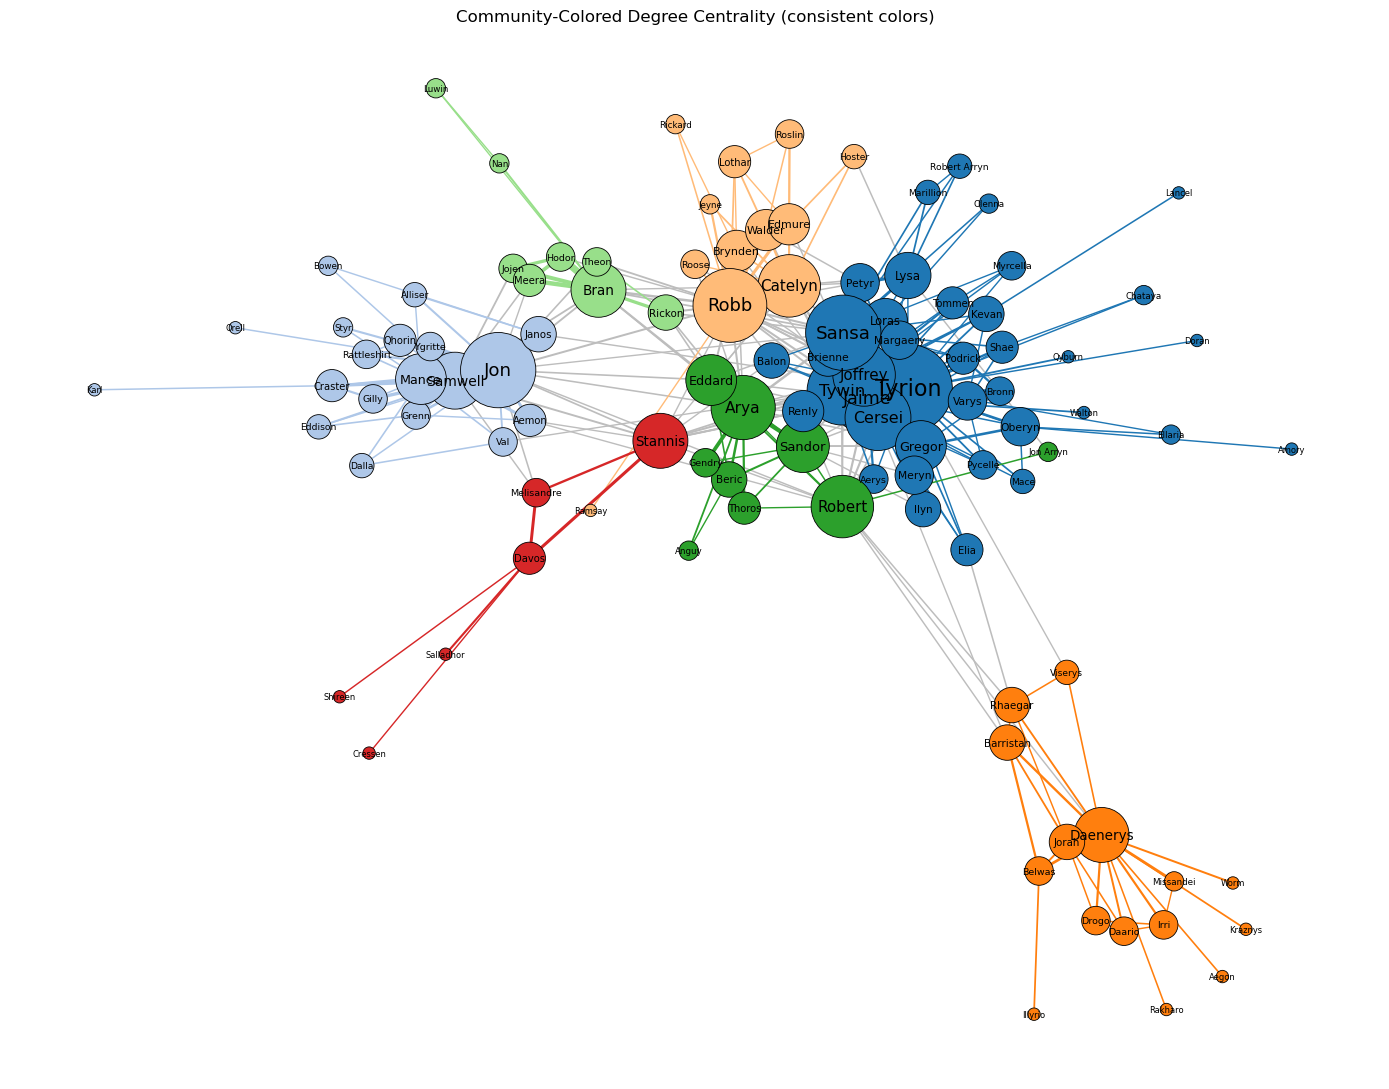

In [ ]:
# --- Degree Centrality Visualization ---
vals = np.array([deg_c[n] for n in G]); norm = (vals - vals.min())/(np.ptp(vals)+1e-12)
sizes = 80 + 4000*norm
labelsizes = 6 + 10*norm

plt.figure(figsize=(14,11))
# cross-community (gray)
nx.draw_networkx_edges(G, pos,
    edgelist=[(u,v) for u,v,_ in cross_edges],
    width=[edge_width(d["weight"]) for _,_,d in cross_edges], edge_color="#BDBDBD")
# intra-community (colored)
for cid, elist in intra_by_comm.items():
    nx.draw_networkx_edges(G, pos,
        edgelist=[(u,v) for u,v,_ in elist],
        width=[edge_width(d["weight"]) for _,_,d in elist],
        edge_color=comm_to_color[cid])
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=[comm_to_color[part[n]] for n in G],
                       linewidths=0.6, edgecolors="black")
for n,(x,y),fs in zip(G.nodes(), [pos[n] for n in G], labelsizes):
    plt.text(x,y,str(n),fontsize=float(fs),ha="center",va="center")
plt.title("Community-Colored Degree Centrality (consistent colors)"); plt.axis("off"); plt.tight_layout(); plt.show()


## Step 4. Betweenness Centrality (weighted)

### Computation & Visualization

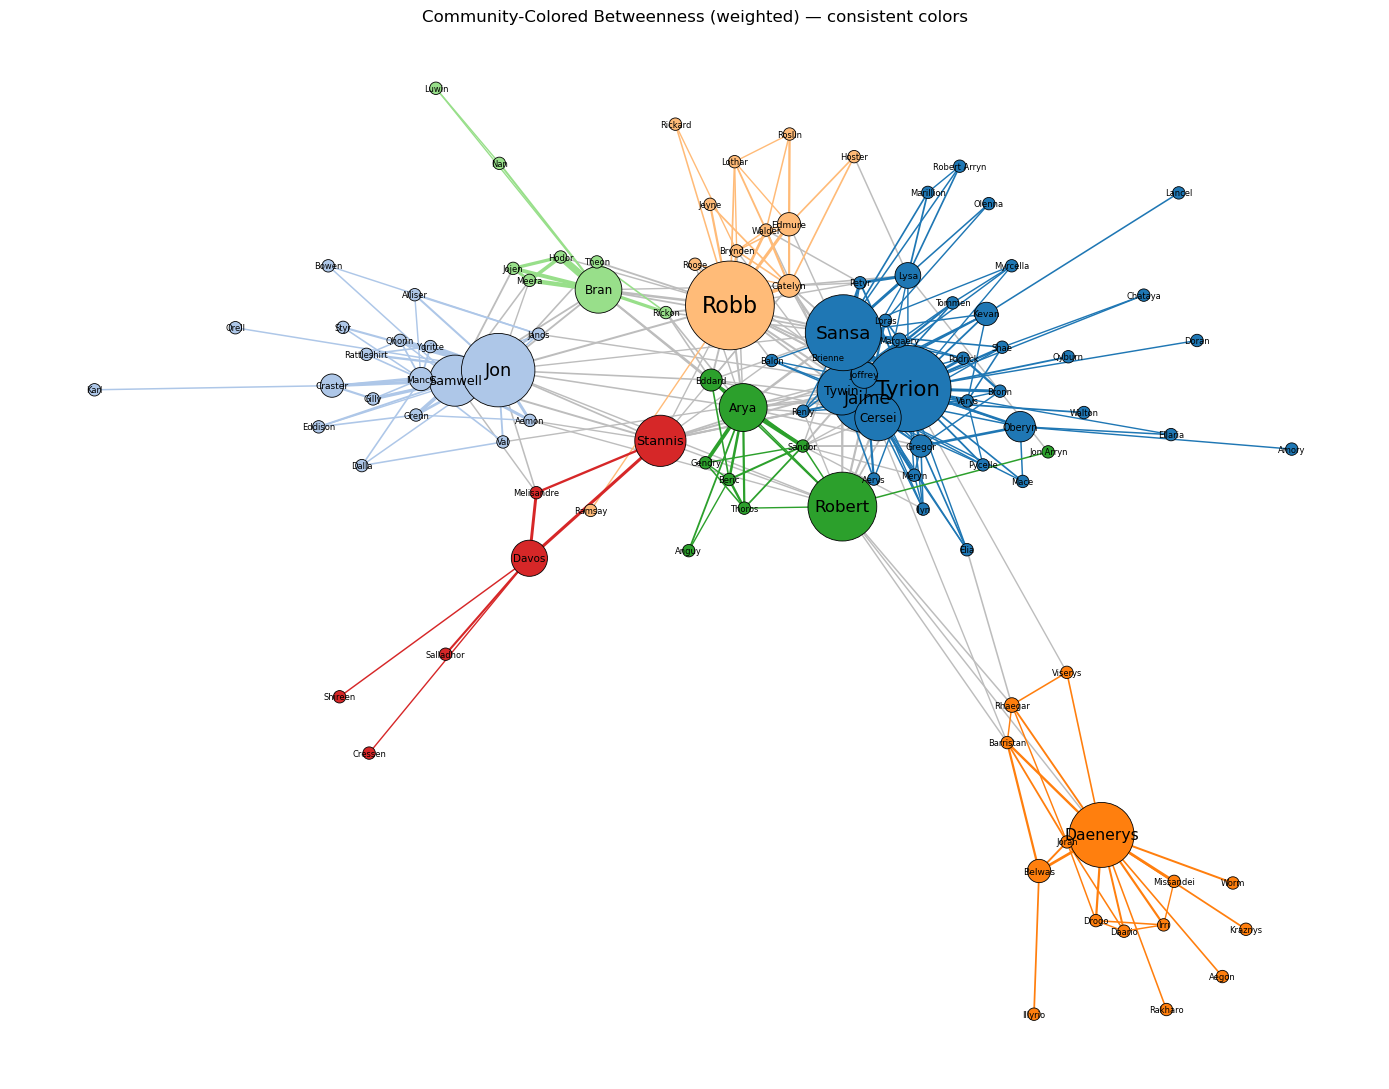

In [16]:
for u,v,d in G.edges(data=True): d["dist"] = 1.0/(d["weight"]+1e-12)
bc_w = nx.betweenness_centrality(G, normalized=True, weight="dist")
vals = np.array([bc_w[n] for n in G]); norm = (vals - vals.min())/(np.ptp(vals)+1e-12)
sizes = 80 + 4000*norm; labelsizes = 6 + 10*norm

plt.figure(figsize=(14,11))
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in cross_edges],
    width=[edge_width(d["weight"]) for _,_,d in cross_edges], edge_color="#BDBDBD")
for cid, elist in intra_by_comm.items():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in elist],
        width=[edge_width(d["weight"]) for _,_,d in elist], edge_color=comm_to_color[cid])
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=[comm_to_color[part[n]] for n in G],
                       linewidths=0.6, edgecolors="black")
for n,(x,y),fs in zip(G.nodes(), [pos[n] for n in G], labelsizes):
    plt.text(x,y,str(n),fontsize=float(fs),ha="center",va="center")
plt.title("Community-Colored Betweenness (weighted) — consistent colors"); plt.axis("off"); plt.tight_layout(); plt.show()


### # Edge Betweenness (to highlight bridge ties)

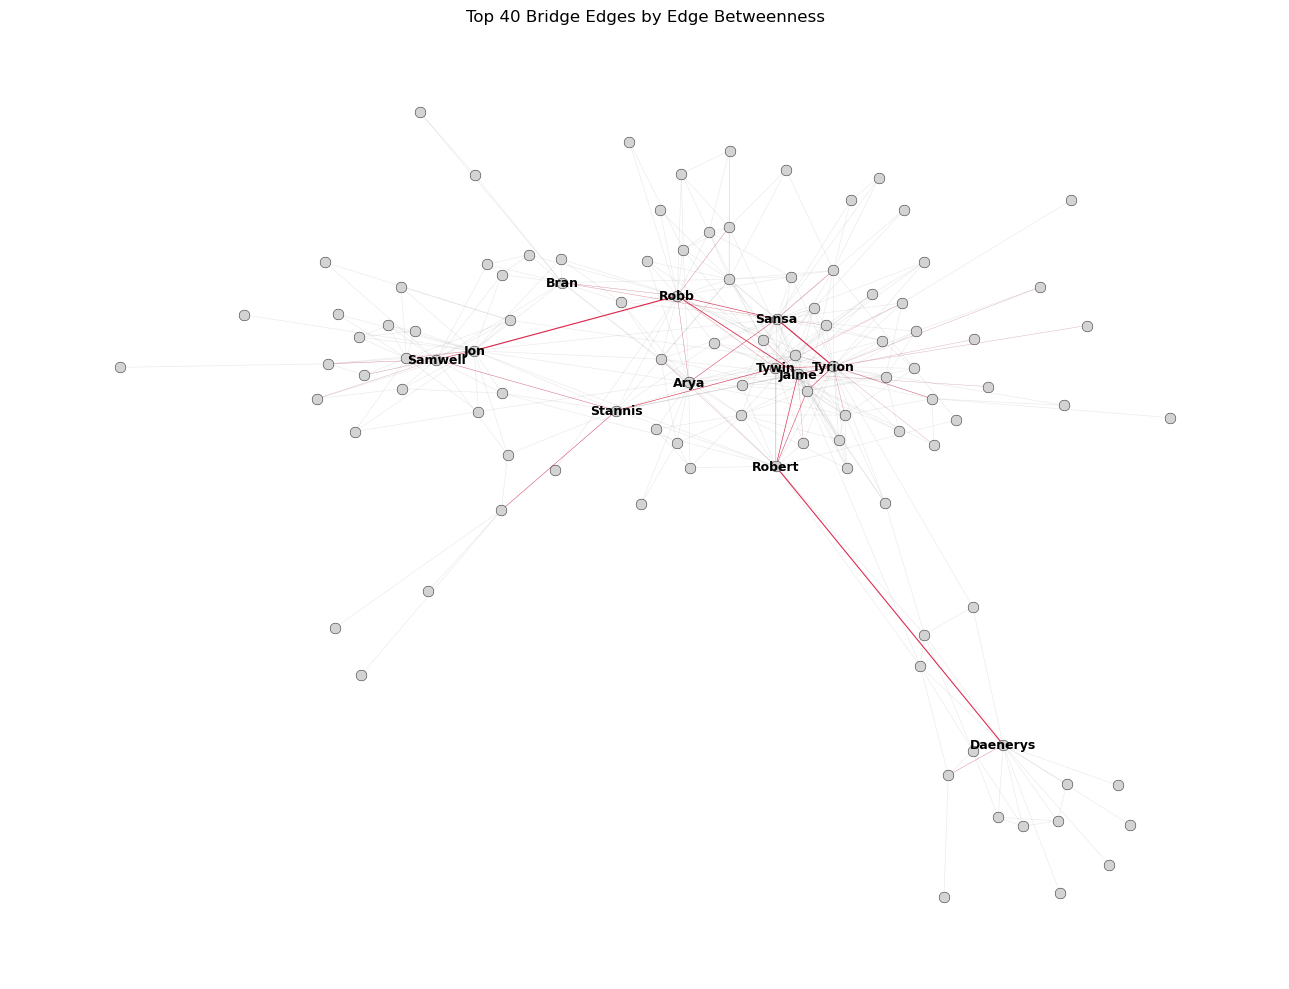

In [17]:
# Edge betweenness using same distance
ebc = nx.edge_betweenness_centrality(G, normalized=True, weight="dist")

# Top K nodes by node betweenness
bc_w = nx.betweenness_centrality(G, normalized=True, weight="dist")
topK = sorted(bc_w, key=bc_w.get, reverse=True)[:12]

# Draw only the top bridge edges
m = 40  # number of edges to highlight
top_edges = sorted(ebc, key=ebc.get, reverse=True)[:m]

plt.figure(figsize=(13,10))
nx.draw_networkx_nodes(G, pos, node_size=60, node_color="lightgray", edgecolors="black", linewidths=0.3)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.15, edge_color="gray")
nx.draw_networkx_edges(G, pos, edgelist=top_edges, width=[4*ebc[e] for e in top_edges], edge_color="crimson", alpha=0.9)
nx.draw_networkx_labels(G, pos, labels={n:n for n in topK}, font_size=9, font_weight="bold")
plt.title(f"Top {m} Bridge Edges by Edge Betweenness")
plt.axis("off"); plt.tight_layout(); plt.show()


## Step 5. Eigenvector Centrality

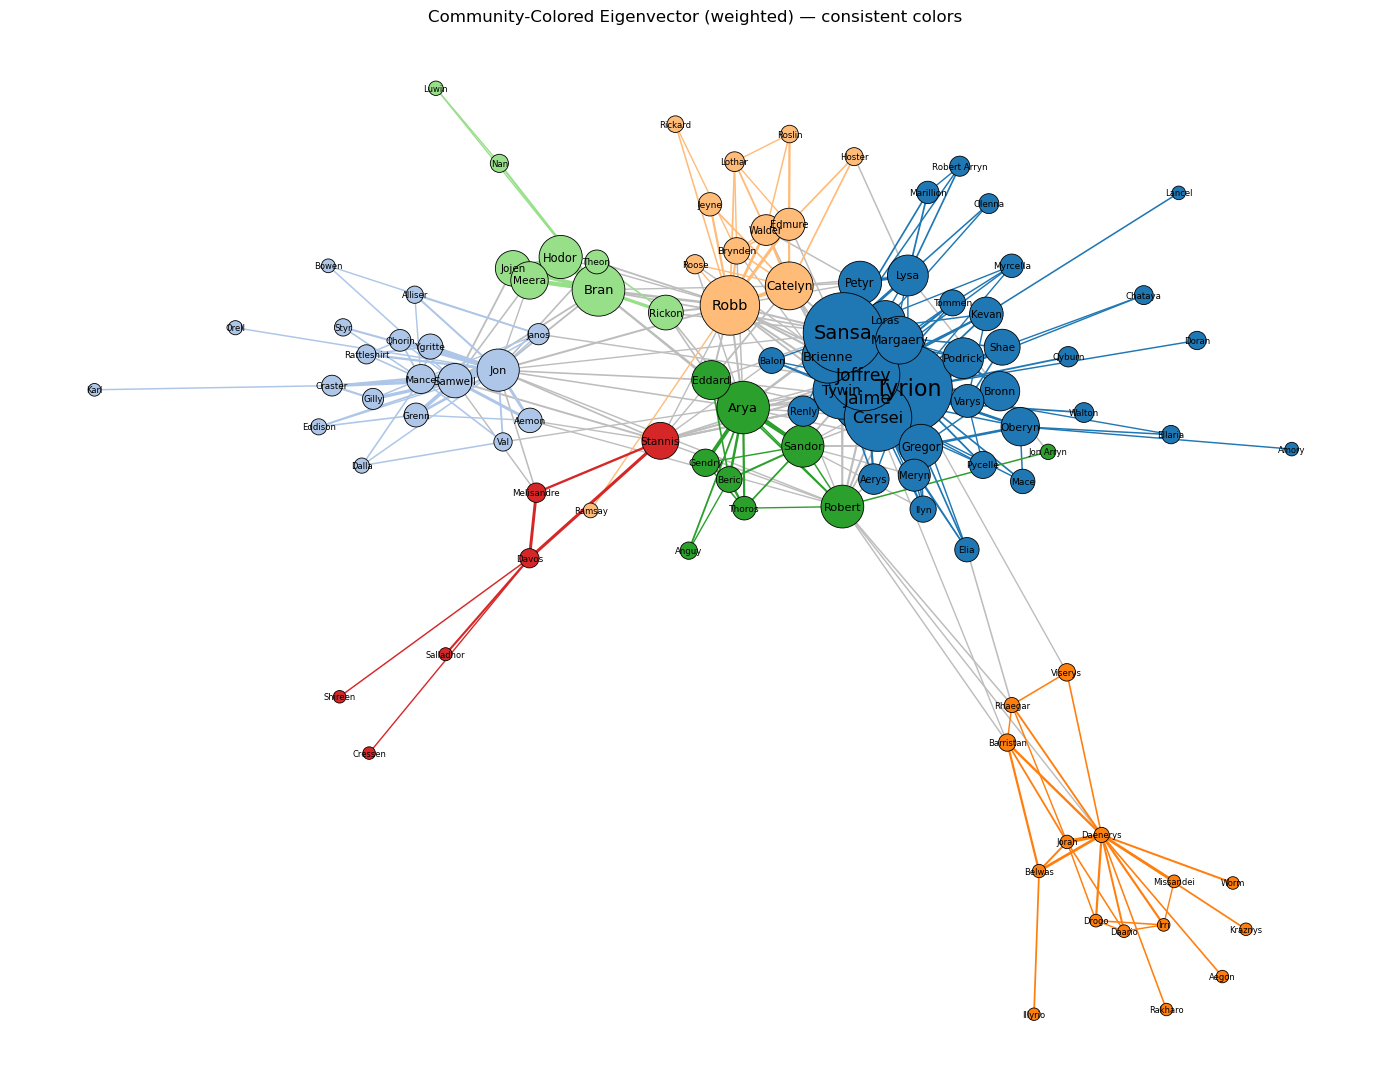

In [18]:
ec = nx.eigenvector_centrality(G, max_iter=2000, tol=1e-7, weight="weight")
vals = np.array([ec[n] for n in G]); norm = (vals - vals.min())/(np.ptp(vals)+1e-12)
sizes = 80 + 4000*norm; labelsizes = 6 + 10*norm

plt.figure(figsize=(14,11))
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in cross_edges],
    width=[edge_width(d["weight"]) for _,_,d in cross_edges], edge_color="#BDBDBD")
for cid, elist in intra_by_comm.items():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in elist],
        width=[edge_width(d["weight"]) for _,_,d in elist], edge_color=comm_to_color[cid])
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=[comm_to_color[part[n]] for n in G],
                       linewidths=0.6, edgecolors="black")
for n,(x,y),fs in zip(G.nodes(), [pos[n] for n in G], labelsizes):
    plt.text(x,y,str(n),fontsize=float(fs),ha="center",va="center")
plt.title("Community-Colored Eigenvector (weighted) — consistent colors"); plt.axis("off"); plt.tight_layout(); plt.show()


## # A summary comparison table
Showing the top 10 characters by three main metrics:
- Degree centrality (connectivity/popularity)
- Betweenness centrality (weighted) (brokerage)
- Eigenvector centrality (weighted) (influence among influential nodes)

In [19]:
import pandas as pd
import networkx as nx

# --- assuming you already have the graph G built and weighted ---

# 1) Degree centrality (unweighted)
deg_c = nx.degree_centrality(G)

# 2) Weighted betweenness (using distance = 1/weight)
for u, v, d in G.edges(data=True):
    d["dist"] = 1.0 / (d["weight"] + 1e-12)
bc_w = nx.betweenness_centrality(G, normalized=True, weight="dist")

# 3) Weighted eigenvector centrality
ec_w = nx.eigenvector_centrality(G, max_iter=2000, tol=1e-07, weight="weight")

# Combine
df_compare = pd.DataFrame({
    "Character": list(G.nodes()),
    "DegreeCentrality": [deg_c[n] for n in G],
    "BetweennessWeighted": [bc_w[n] for n in G],
    "EigenvectorWeighted": [ec_w[n] for n in G],
})

# Normalize each metric for visual comparability (0–1 range)
for col in ["DegreeCentrality", "BetweennessWeighted", "EigenvectorWeighted"]:
    df_compare[col] = (df_compare[col] - df_compare[col].min()) / (df_compare[col].max() - df_compare[col].min())

# Rank by each
df_compare["Rank_Degree"] = df_compare["DegreeCentrality"].rank(ascending=False)
df_compare["Rank_Betweenness"] = df_compare["BetweennessWeighted"].rank(ascending=False)
df_compare["Rank_Eigenvector"] = df_compare["EigenvectorWeighted"].rank(ascending=False)

# Sort by overall average rank
df_compare["AverageRank"] = df_compare[["Rank_Degree", "Rank_Betweenness", "Rank_Eigenvector"]].mean(axis=1)
df_top10 = df_compare.sort_values("AverageRank").head(10)

print(df_top10[["Character", "Rank_Degree", "Rank_Betweenness", "Rank_Eigenvector"]].round(1))


   Character  Rank_Degree  Rank_Betweenness  Rank_Eigenvector
6     Tyrion          1.0               2.0               1.0
50     Sansa          2.5               3.0               2.0
48      Robb          4.0               1.0               6.0
4      Jaime          5.0               5.0               3.0
7      Tywin          6.0              10.0               7.0
21       Jon          2.5               4.0              18.0
17    Cersei          7.0              13.0               5.0
12      Arya          8.0              11.0               9.0
20   Joffrey         10.0              16.0               4.0
5     Robert         10.0               6.0              16.0


### Visualization The Table as a Heatmap:

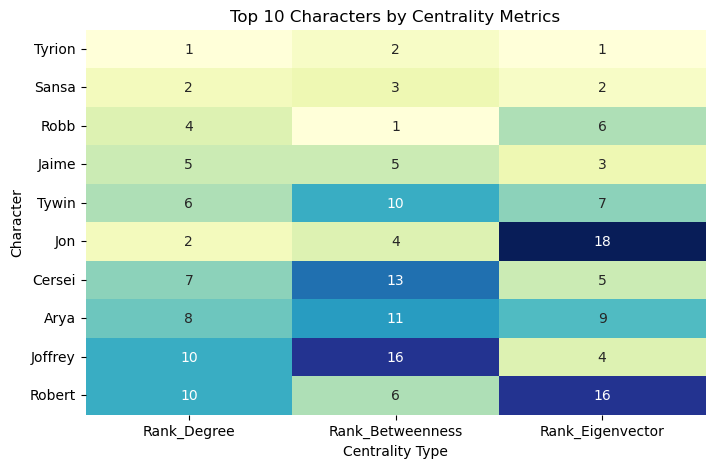

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(df_top10.set_index("Character")[["Rank_Degree","Rank_Betweenness","Rank_Eigenvector"]],
            annot=True, cmap="YlGnBu", cbar=False, fmt=".0f")
plt.title("Top 10 Characters by Centrality Metrics")
plt.xlabel("Centrality Type")
plt.ylabel("Character")
plt.show()
